In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2

In [ ]:
test_file = '/content/credit_test.csv'
train_file = '/content/credit_train.csv'

df_test = pd.read_csv(test_file)
df_train = pd.read_csv(train_file)

In [ ]:
df_train.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0



1.   What is the most common reason for a loan?
2.   What has most impact on whether loan is fully repaid or not?
3.   What factors impact number of credit problems and bankruptcies?



**Pre-processing data**

In [ ]:
# Change dataframe columns and datatypes to more managable types

df_train.columns


Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [ ]:
df_train.columns = df_train.columns.str.replace(' ', '_')

df_test.columns = df_test.columns.str.replace(' ', '_')

In [ ]:
df_train.drop(["Loan_ID", "Customer_ID"], inplace=True, axis=1)

df_test.drop(["Loan_ID", "Customer_ID"], inplace=True, axis=1)

In [ ]:
df_train.isna().sum()

Loan_Status                       514
Current_Loan_Amount               514
Term                              514
Credit_Score                    19668
Annual_Income                   19668
Years_in_current_job             4736
Home_Ownership                    514
Purpose                           514
Monthly_Debt                      514
Years_of_Credit_History           514
Months_since_last_delinquent    53655
Number_of_Open_Accounts           514
Number_of_Credit_Problems         514
Current_Credit_Balance            514
Maximum_Open_Credit               516
Bankruptcies                      718
Tax_Liens                         524
dtype: int64

In [ ]:
# Drop column becuase 50% null values

df_train.drop("Months_since_last_delinquent", inplace=True, axis=1)

df_test.drop("Months_since_last_delinquent", inplace=True, axis=1)

In [ ]:
# Find appropriate value to replace NA for credit score and annual income

df_train["Credit_Score"].fillna(df_train["Credit_Score"].median(), inplace=True)
df_train["Annual_Income"].fillna(df_train["Annual_Income"].median(), inplace=True)

df_test["Credit_Score"].fillna(df_test["Credit_Score"].median(), inplace=True)
df_test["Annual_Income"].fillna(df_test["Annual_Income"].median(), inplace=True)

In [ ]:
# drop the last of the NA values as they are less than 1% of data

df_train.dropna(inplace=True)

df_test.dropna(inplace=True)

In [ ]:
df_train.isna().sum()

Loan_Status                  0
Current_Loan_Amount          0
Term                         0
Credit_Score                 0
Annual_Income                0
Years_in_current_job         0
Home_Ownership               0
Purpose                      0
Monthly_Debt                 0
Years_of_Credit_History      0
Number_of_Open_Accounts      0
Number_of_Credit_Problems    0
Current_Credit_Balance       0
Maximum_Open_Credit          0
Bankruptcies                 0
Tax_Liens                    0
dtype: int64

In [ ]:
df_train["Purpose"].unique()

array(['Home Improvements', 'Debt Consolidation', 'Buy House',
       'Business Loan', 'Buy a Car', 'other', 'major_purchase',
       'Take a Trip', 'Other', 'small_business', 'Medical Bills',
       'wedding', 'vacation', 'Educational Expenses', 'moving',
       'renewable_energy'], dtype=object)

In [ ]:
# Consolidating similar values together for example other and Other

df_train.loc[ df_train['Purpose'] == 'other', 'Purpose'] = 'Other'
df_train.loc[ df_train['Purpose'] == 'Take a Trip', 'Purpose'] = 'vacation'
df_train.loc[ df_train['Purpose'] == 'small_business', 'Purpose'] = 'Business Loan'

df_test.loc[ df_test['Purpose'] == 'other', 'Purpose'] = 'Other'
df_test.loc[ df_test['Purpose'] == 'Take a Trip', 'Purpose'] = 'vacation'
df_test.loc[ df_test['Purpose'] == 'small_business', 'Purpose'] = 'Business Loan'

In [ ]:
df_train["Home_Ownership"].unique()

array(['Home Mortgage', 'Own Home', 'Rent', 'HaveMortgage'], dtype=object)

In [ ]:
df_train.loc[ df_train['Home_Ownership'] == 'HaveMortgage', 'Home_Ownership'] = 'Home Mortgage'

df_test.loc[ df_test['Home_Ownership'] == 'HaveMortgage', 'Home_Ownership'] = 'Home Mortgage'

In [ ]:
df_train["Home_Ownership"].unique()

array(['Home Mortgage', 'Own Home', 'Rent'], dtype=object)

In [ ]:
# Now convert datatypes to usable types for the models, creating dummy variables 

In [ ]:
df_train.head()

,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Annual_Income,Years_in_current_job,Home_Ownership,Purpose,Monthly_Debt,Years_of_Credit_History,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,724.0,1174162.0,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,724.0,1174162.0,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0


In [ ]:
# Noticed the Income column is too many decimal places, so we will round and convert to int

df_train["Annual_Income"][1]

1174162.0

In [ ]:
df_train["Annual_Income"] = df_train["Annual_Income"].round(0)
df_train["Credit_Score"] = df_train["Credit_Score"].round(0)

df_test["Annual_Income"] = df_test["Annual_Income"].round(0)
df_test["Credit_Score"] = df_test["Credit_Score"].round(0)

In [ ]:
# Convert Years in current job column to numerical only (remove years string)
df_train['Years_in_current_job'] = df_train['Years_in_current_job'].str.extract('(\d+)')
df_train['Years_in_current_job'] = df_train['Years_in_current_job'].astype(int)

df_test['Years_in_current_job'] = df_test['Years_in_current_job'].str.extract('(\d+)')
df_test['Years_in_current_job'] = df_test['Years_in_current_job'].astype(int)

In [ ]:
df_train.head()

,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Annual_Income,Years_in_current_job,Home_Ownership,Purpose,Monthly_Debt,Years_of_Credit_History,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,Fully Paid,262328.0,Short Term,724.0,1174162.0,10,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8,Own Home,Debt Consolidation,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0
3,Fully Paid,347666.0,Long Term,721.0,806949.0,3,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
4,Fully Paid,176220.0,Short Term,724.0,1174162.0,5,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0


array([[<Axes: title={'center': 'Current_Loan_Amount'}>]], dtype=object)

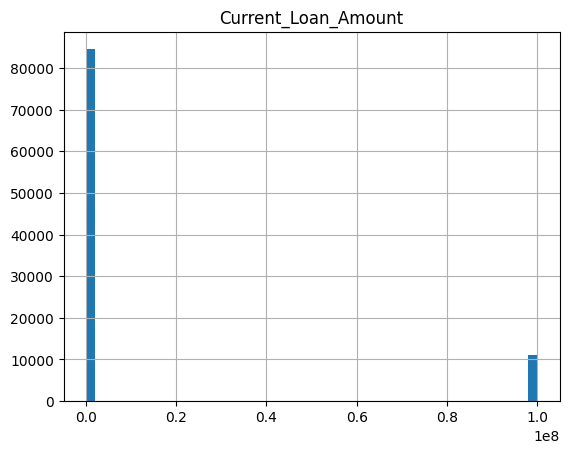

In [ ]:
df_train.hist(column="Current_Loan_Amount", bins=50)
#Outlier has massive affect on data distribution 
#Consider removing or ignoring this row

<Axes: >

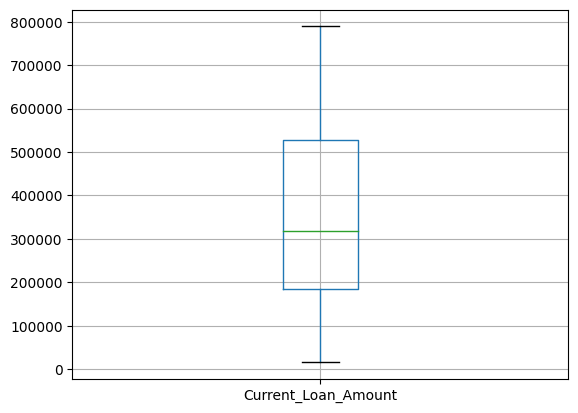

In [ ]:
df_train[["Current_Loan_Amount"]].boxplot(showfliers=False)

In [ ]:
# We will remove outliers before modelling 


In [ ]:
df_train.columns

Index(['Loan_Status', 'Current_Loan_Amount', 'Term', 'Credit_Score',
       'Annual_Income', 'Years_in_current_job', 'Home_Ownership', 'Purpose',
       'Monthly_Debt', 'Years_of_Credit_History', 'Number_of_Open_Accounts',
       'Number_of_Credit_Problems', 'Current_Credit_Balance',
       'Maximum_Open_Credit', 'Bankruptcies', 'Tax_Liens'],
      dtype='object')